Files already downloaded and verified
Epoch [1/1000] Step [0/40] Loss D: 1.8654, Loss G: 2.6735
Epoch [2/1000] Step [0/40] Loss D: 0.1679, Loss G: 7.9574
Epoch [3/1000] Step [0/40] Loss D: 0.9564, Loss G: 19.2314
Epoch [4/1000] Step [0/40] Loss D: 0.4849, Loss G: 2.3206
Epoch [5/1000] Step [0/40] Loss D: 1.0167, Loss G: 10.4882
Epoch [6/1000] Step [0/40] Loss D: 0.4736, Loss G: 7.5791
Epoch [7/1000] Step [0/40] Loss D: 0.1051, Loss G: 7.0098
Epoch [8/1000] Step [0/40] Loss D: 0.1108, Loss G: 5.3709
Epoch [9/1000] Step [0/40] Loss D: 0.2677, Loss G: 10.9443
Epoch [10/1000] Step [0/40] Loss D: 0.1402, Loss G: 6.3333
Epoch [11/1000] Step [0/40] Loss D: 0.1291, Loss G: 5.1351
Epoch [12/1000] Step [0/40] Loss D: 0.6957, Loss G: 3.6527
Epoch [13/1000] Step [0/40] Loss D: 0.9038, Loss G: 10.3044
Epoch [14/1000] Step [0/40] Loss D: 0.3261, Loss G: 5.3375
Epoch [15/1000] Step [0/40] Loss D: 0.3102, Loss G: 7.8146
Epoch [16/1000] Step [0/40] Loss D: 0.4555, Loss G: 5.6178
Epoch [17/1000] Step [0

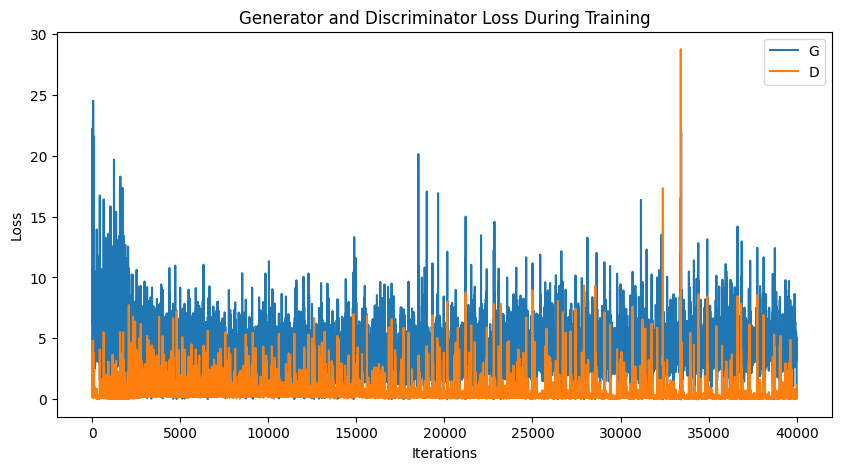

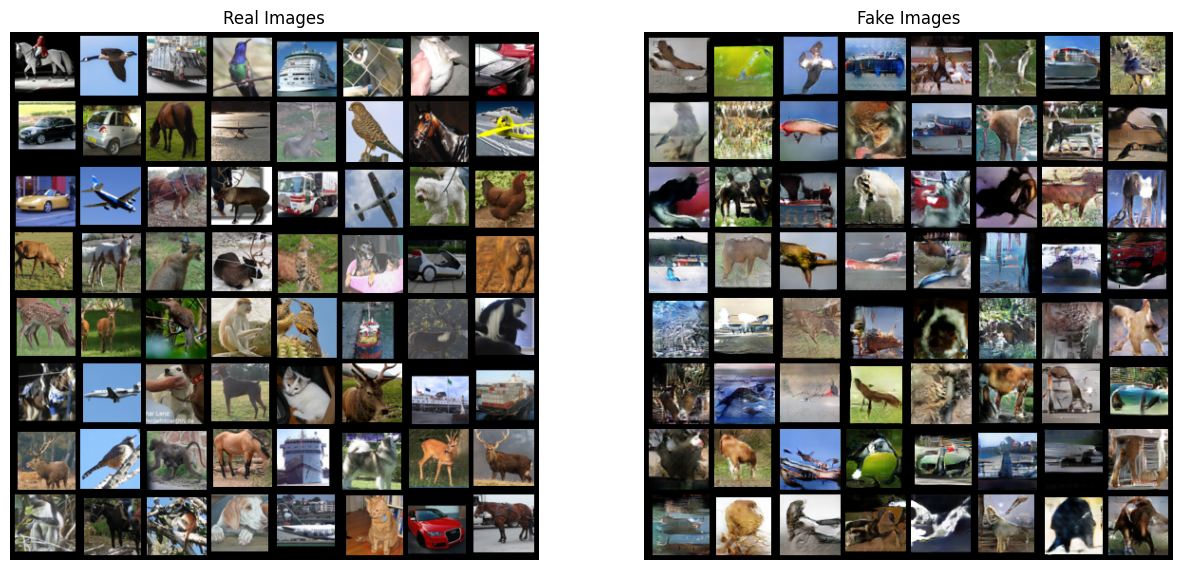

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
image_size = 64
noise_dim = 100
num_epochs = 1000
lr = 0.0002
beta1 = 0.6

# Data augmentation and transforms for STL-10 and CIFAR-10
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(image_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load datasets
stl10_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
stl10_loader = DataLoader(stl10_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Initialize Generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss and optimizer
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Create a batch of latent vectors (noise) for visualization
fixed_noise = torch.randn(64, noise_dim, 1, 1, device=device)

# Lists to store the loss for plotting later
G_losses = []
D_losses = []

# Training Loop for GAN
for epoch in range(num_epochs):
    for i, data in enumerate(stl10_loader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)  # Real label = 1

        # Forward pass real batch through D
        output = netD(real_images)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        # Generate fake images batch with G
        noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
        fake_images = netG(noise)

        # Label for fake images
        label.fill_(0.0)  # Fake label = 0

        # Forward pass fake batch through D
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()

        # Update D
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(1.0)  # Generator wants D to believe fake images are real

        # Forward pass fake images through D
        output = netD(fake_images)
        lossG = criterion(output, label)
        lossG.backward()

        # Update G
        optimizerG.step()

        # Store losses for later plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Print statistics
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(stl10_loader)}] '
                  f'Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')

    # Save fake images during training
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        #vutils.save_image(fake, f'fake_images_epoch_{epoch+1}.png', normalize=True)

# After training is done, let's plot the losses

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Comparing some real and fake images

# Grab a batch of real images from the dataloader
real_batch = next(iter(stl10_loader))

plt.figure(figsize=(15,15))
# Plot real images
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot fake images from the last epoch
fake_batch = netG(fixed_noise).detach().cpu()
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch, padding=5, normalize=True),(1,2,0)))
plt.show()


In [2]:
import os
from PIL import Image
import pandas as pd
import torch
from torchvision import datasets, transforms

# Set up the folder path and device
test_folder = "./test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the image transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64, change this size as needed
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images (change mean/std as needed)
])

# Load the dataset
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

# Create the dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Assume your model is loaded and called netG
netG.eval()  # Set the model to evaluation mode

# Lists to store filenames and predictions
file_list = []
predictions = []

# Track the current index to avoid duplicate file names
current_index = 0

# Loop over the test dataloader
with torch.no_grad():
    for inputs, _ in test_loader:  # The "_" ignores the label since we don't need it
        inputs = inputs.to(device)
        
        # Make predictions with the model
        outputs = netD(inputs)
        
        # Round the predictions, move to CPU, and convert to NumPy array
        rounded_outputs = torch.round(outputs).cpu().numpy().astype(int)  # Cast to integer
        
        # Get the file names using the global index
        batch_files = [os.path.basename(test_loader.dataset.samples[i + current_index][0]) for i in range(len(inputs))]
        current_index += len(inputs)  # Update the index by the size of the current batch
        
        # Store the results
        file_list.extend(batch_files)
        predictions.extend(rounded_outputs)  # Add integer predictions

# Create a DataFrame with filenames and predictions
df = pd.DataFrame({
    "Filename": file_list,
    "Real": predictions
})

# Save the DataFrame to a CSV file
df.to_csv("./predictions2.csv", index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
